In [103]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import  Lasso
from sklearn.ensemble import  RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import KNNImputer, SimpleImputer

In [104]:
data = pd.read_csv('BigCitiesHealth.csv')

In [105]:
data.shape

(148292, 31)

In [106]:
data.describe()

,geo_fips_code,value,date_label,value_95_ci_low,value_95_ci_high,value_90_ci_low,value_90_ci_high
count,1.471950e+05,147522.000000,148292.000000,93378.000000,93388.000000,0.0,0.0
mean,2.880322e+06,830.377923,2015.227996,468.838106,568.740516,NaN,NaN
std,1.697827e+06,4304.120276,3.112534,1742.895189,2043.575501,NaN,NaN
min,4.550000e+05,-1.052184,2010.000000,-148.037039,0.458320,NaN,NaN
25%,8.200000e+05,10.851578,2013.000000,9.337966,15.449973,NaN,NaN
50%,2.938000e+06,26.743773,2015.000000,23.259248,34.061614,NaN,NaN
75%,4.748000e+06,77.161225,2018.000000,109.929802,149.434371,NaN,NaN
max,5.553000e+06,99408.000000,2020.000000,22650.600880,29193.761110,NaN,NaN


In [107]:

data.dtypes

metric_item_label                   object
metric_cat_label                    object
metric_subcat_label                 object
metric_item_label_subtitle          object
metric_cat_item_yaxis_label         object
metric_source_desc_label_fn         object
metric_source_desc_label_url_fn     object
geo_label_city                      object
geo_label_state                     object
geo_label_citystate                 object
geo_fips_code                      float64
value                              float64
date_label                           int64
geo_label_proxy_or_real             object
geo_label_proxy_footnote            object
geo_fips_desc                       object
date_label_proxy_or_real            object
date_label_proxy_footnote           object
value_ci_flag_yesno                 object
value_95_ci_low                    float64
value_95_ci_high                   float64
value_90_ci_low                    float64
value_90_ci_high                   float64
geo_strata_

In [108]:
outcome_counts = data.groupby(['geo_label_city', 'metric_item_label']).size().reset_index(name='count')


In [109]:
top_outcomes = outcome_counts.groupby('metric_item_label').sum().sort_values(by='count', ascending=False).head(10).index


In [110]:
outcome_counts_top = outcome_counts[outcome_counts['metric_item_label'].isin(top_outcomes)]


In [111]:
pivot_table = pd.pivot_table(outcome_counts_top, values='count', index='geo_label_city', columns='metric_item_label', fill_value=0)


In [112]:
data = data.drop('metric_source_desc_label_url_fn', axis = 1)

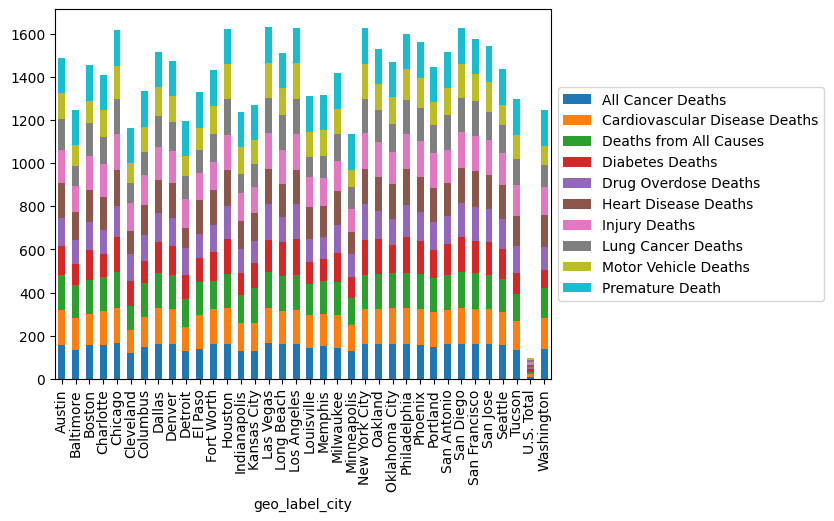

In [113]:
ax = pivot_table.plot(kind='bar', stacked=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



# Data PreProcessing

In [114]:
data.isnull().sum()

metric_item_label                   0
metric_cat_label                    0
metric_subcat_label                 0
metric_item_label_subtitle          0
metric_cat_item_yaxis_label         0
metric_source_desc_label_fn         0
geo_label_city                      0
geo_label_state                  1097
geo_label_citystate                 0
geo_fips_code                    1097
value                             770
date_label                          0
geo_label_proxy_or_real             0
geo_label_proxy_footnote       133002
geo_fips_desc                       0
date_label_proxy_or_real            0
date_label_proxy_footnote      104164
value_ci_flag_yesno                 0
value_95_ci_low                 54914
value_95_ci_high                54904
value_90_ci_low                148292
value_90_ci_high               148292
geo_strata_region                1097
geo_strata_poverty               1097
geo_strata_Population            1097
geo_strata_PopDensity            1097
geo_strata_S

Deleting the columns that contain more than 50% (74'146) missing values.

In [115]:
missing_values = data.isnull().mean()
columns_to_drop = list(missing_values[missing_values > 0.5].index)
data = data.drop(columns_to_drop, axis=1)
columns_to_drop

['geo_label_proxy_footnote',
 'date_label_proxy_footnote',
 'value_90_ci_low',
 'value_90_ci_high',
 'strata_race_sex_label']

Detect Numerical and Categorical Features

In [116]:
num_features = data.select_dtypes(include=['float64', 'int64']).columns
cat_features = data.select_dtypes(include=['object']).columns
num_features, cat_features

(Index(['geo_fips_code', 'value', 'date_label', 'value_95_ci_low',
        'value_95_ci_high'],
       dtype='object'),
 Index(['metric_item_label', 'metric_cat_label', 'metric_subcat_label',
        'metric_item_label_subtitle', 'metric_cat_item_yaxis_label',
        'metric_source_desc_label_fn', 'geo_label_city', 'geo_label_state',
        'geo_label_citystate', 'geo_label_proxy_or_real', 'geo_fips_desc',
        'date_label_proxy_or_real', 'value_ci_flag_yesno', 'geo_strata_region',
        'geo_strata_poverty', 'geo_strata_Population', 'geo_strata_PopDensity',
        'geo_strata_Segregation', 'strata_race_label', 'strata_sex_label'],
       dtype='object'))

Filling in the missing spots (KNN in numerical and Simple for numerical)

In [117]:
imputerKNN = KNNImputer(n_neighbors=3)
imputerCat = SimpleImputer(strategy='most_frequent')
imputerNum = SimpleImputer(strategy='median')

In [118]:
data[cat_features] = imputerCat.fit_transform(data[cat_features])


Since all have high variance but not "date_label" we use median for datasets with high variance and mean imputation for data with low variance.(But "date_label" has no missing value so using median for all)

In [119]:
data[num_features] = imputerNum.fit_transform(data[num_features])

In [120]:
data.isna().sum()

metric_item_label              0
metric_cat_label               0
metric_subcat_label            0
metric_item_label_subtitle     0
metric_cat_item_yaxis_label    0
metric_source_desc_label_fn    0
geo_label_city                 0
geo_label_state                0
geo_label_citystate            0
geo_fips_code                  0
value                          0
date_label                     0
geo_label_proxy_or_real        0
geo_fips_desc                  0
date_label_proxy_or_real       0
value_ci_flag_yesno            0
value_95_ci_low                0
value_95_ci_high               0
geo_strata_region              0
geo_strata_poverty             0
geo_strata_Population          0
geo_strata_PopDensity          0
geo_strata_Segregation         0
strata_race_label              0
strata_sex_label               0
dtype: int64

In [121]:
#data[num_features] = imputerKNN.fit_transform(data[num_features])


No more missing values. Now is time for data analysis and feature selection

In [122]:
data.describe()

,geo_fips_code,value,date_label,value_95_ci_low,value_95_ci_high
count,1.482920e+05,148292.000000,148292.000000,148292.000000,148292.000000
mean,2.880748e+06,826.205087,2015.227996,303.835831,370.779665
std,1.691543e+06,4293.319708,3.112534,1399.674150,1642.145192
min,4.550000e+05,-1.052184,2010.000000,-148.037039,0.458320
25%,8.200000e+05,10.913543,2013.000000,15.860769,24.484818
50%,2.938000e+06,26.743773,2015.000000,23.259248,34.061614
75%,4.748000e+06,76.710433,2018.000000,36.684472,52.822604
max,5.553000e+06,99408.000000,2020.000000,22650.600880,29193.761110


For value_95_ci_low and value_95_ci_high, the mean has drastically changed. Maybe use another filling type.

Now encode Categorical Features:

In [123]:
data.values.shape

(148292, 25)

In [142]:
X = data.drop(['metric_item_label'], axis = 1)
y = data['metric_item_label']

In [143]:
X.isna().sum()

metric_cat_label               0
metric_subcat_label            0
metric_item_label_subtitle     0
metric_cat_item_yaxis_label    0
metric_source_desc_label_fn    0
geo_label_city                 0
geo_label_state                0
geo_label_citystate            0
geo_fips_code                  0
value                          0
date_label                     0
geo_label_proxy_or_real        0
geo_fips_desc                  0
date_label_proxy_or_real       0
value_ci_flag_yesno            0
value_95_ci_low                0
value_95_ci_high               0
geo_strata_region              0
geo_strata_poverty             0
geo_strata_Population          0
geo_strata_PopDensity          0
geo_strata_Segregation         0
strata_race_label              0
strata_sex_label               0
dtype: int64

In [144]:
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [146]:
one_hot = OneHotEncoder()
X_train_encoded = one_hot.fit_transform(X_train[categorical_features]).toarray()
X_test_encoded = one_hot.transform(X_test[categorical_features]).toarray()

In [148]:
X_train_final = pd.concat([pd.DataFrame(X_train_encoded, columns=one_hot.get_feature_names_out(categorical_features)), X_train[numerical_features]], axis=1)
X_test_final = pd.concat([pd.DataFrame(X_test_encoded, columns=one_hot.get_feature_names_out(categorical_features)), X_test[numerical_features]], axis=1)


In [149]:
X_train_final.isna().sum()

metric_cat_label_Access to Health Services     23699
metric_cat_label_Chronic Health Conditions     23699
metric_cat_label_Demographics                  23699
metric_cat_label_Infectious Diseases           23699
metric_cat_label_Life Expectancy and Deaths    23699
                                               ...  
geo_fips_code                                  23699
value                                          23699
date_label                                     23699
value_95_ci_low                                23699
value_95_ci_high                               23699
Length: 312, dtype: int64

In [150]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_final, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:15]
top_features = X_train_final.columns[indices]


ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(len(indices)), importances[indices], color='b', align='center')
plt.xticks(range(len(indices)), top_features, rotation=90)
plt.tight_layout()

# Feature Selection


In [ ]:
sc = StandardScaler()

In [ ]:
X_scaled = sc.fit_transform(X)
X_scaled_abs = abs(X_scaled)

Using Lasso

In [ ]:
lasso = Lasso(alpha=0.1)
lasso.fit(X, y)
lasso_coefficiants = lasso.coef_ 

In [ ]:
coef = np.abs(lasso.coef_)
coef_sorted = np.argsort(coef)[::-1]

feature_names = data.columns[coef_sorted[:15]]

Text(0.5, 1.0, 'Top 15 Features Selected by Lasso')

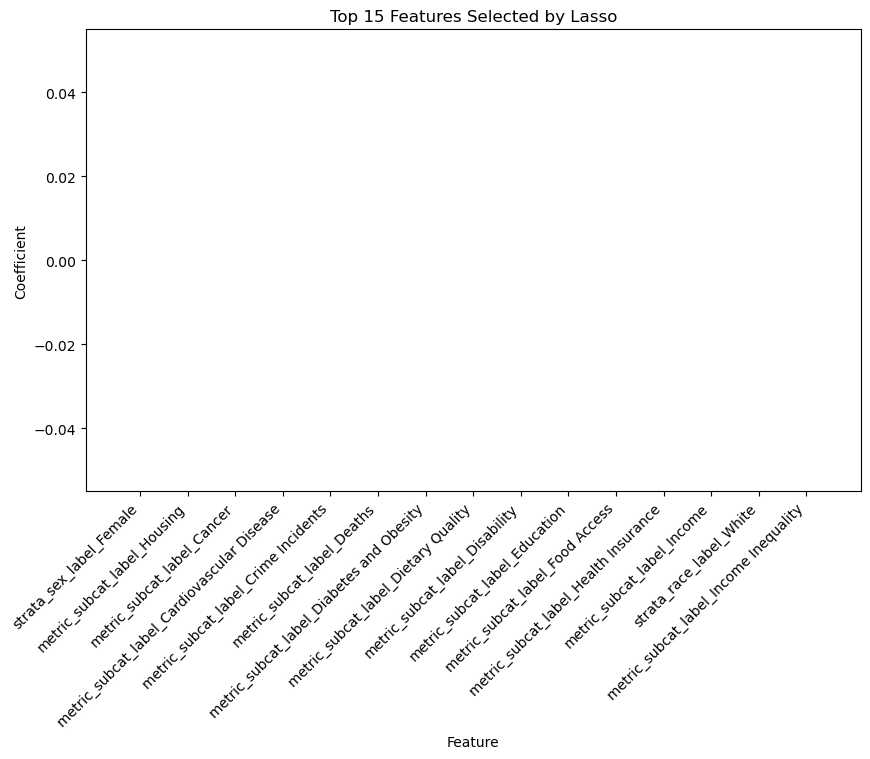

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(feature_names, coef[coef_sorted[:15]])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Top 15 Features Selected by Lasso')

Random Forest Method

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_

# Get the indices of the top 15 features
indices = (-importances).argsort()[:15]
sorted_idx = indices[np.argsort(importances[indices])[::-1]]

# Get feature names
feature_names = X_scaled.columns[sorted_idx]

plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(indices)), importances[indices])
plt.xticks(np.arange(len(indices)), feature_names, rotation=45, ha='right')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Top 15 Features Selected by Random Forest")
plt.tight_layout()

NameError: name 'RandomForestClassifier' is not defined

Pearson

Text(0.5, 1.0, '15 Best Features Selected by Pearson Correlation (Descending Order)')

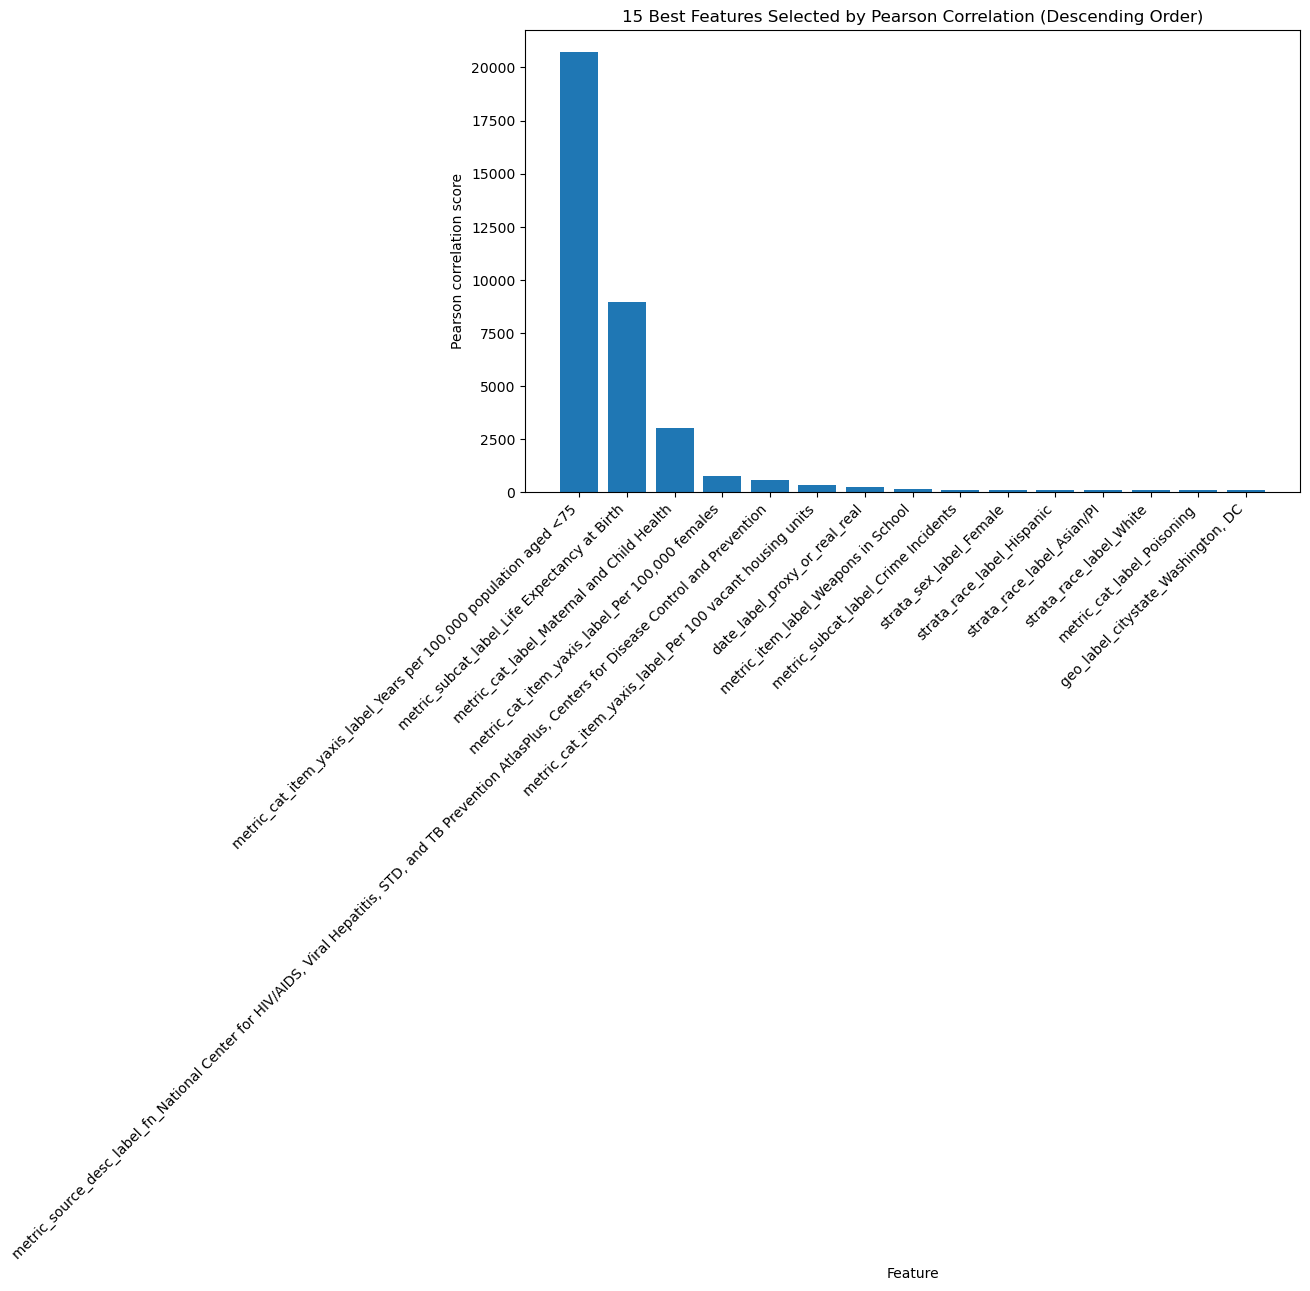

In [ ]:
correlations = np.abs(np.corrcoef(X.T, y)[:4, 4])

pearson_selector = SelectKBest(score_func=f_regression, k=15)
pearson_selector.fit(X, y)
pearson_selected = pearson_selector.get_support(indices=True)

indices = np.argsort(pearson_selector.scores_[pearson_selected])[::-1]

plt.figure(figsize=(10, 6))
plt.bar(np.arange(15), pearson_selector.scores_[pearson_selected][indices])
plt.xticks(np.arange(15), data.columns[pearson_selected][indices], rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("Pearson correlation score")
plt.title("15 Best Features Selected by Pearson Correlation (Descending Order)")

Compare Both

In [ ]:
overlap = set()

# Data Visualisation

In [ ]:
data.describe()

,geo_fips_code,value,date_label,value_95_ci_low,value_95_ci_high,metric_item_label_Adult Mental Distress,metric_item_label_Adult Obesity,metric_item_label_Adult Physical Inactivity,metric_item_label_Adult Smoking,metric_item_label_All Cancer Deaths,...,geo_strata_PopDensity_Lower pop. density (<10k per sq mi),geo_strata_Segregation_Less Segregated (<50%),strata_race_label_American Indian/Alaska Native,strata_race_label_Asian,strata_race_label_Asian/PI,strata_race_label_Black,strata_race_label_Hispanic,strata_race_label_White,strata_sex_label_Female,strata_sex_label_Male
count,1.482920e+05,1.482920e+05,1.482920e+05,1.482920e+05,1.482920e+05,148292.000000,148292.000000,148292.000000,148292.000000,148292.000000,...,148292.000000,148292.000000,148292.000000,148292.000000,148292.000000,148292.000000,148292.000000,148292.000000,148292.000000,148292.000000
mean,9.726363e-16,-9.622103e-17,2.833045e-14,-3.602731e-13,-1.254504e-14,0.002670,0.002670,0.002670,0.002670,0.035882,...,0.807245,0.612919,0.033994,0.034223,0.076464,0.171526,0.151586,0.174993,0.161364,0.184521
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,0.051607,0.051607,0.051607,0.051607,0.185996,...,0.394464,0.487084,0.181214,0.181802,0.265740,0.376970,0.358620,0.379962,0.367868,0.387910
min,-1.436080e+00,-1.926519e-01,-1.679665e+00,-3.193887e-01,-2.212515e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.220463e+00,-1.899212e-01,-7.158167e-01,-2.058388e-01,-2.117952e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.070453e-02,-1.862407e-01,-7.325122e-02,-2.058388e-01,-2.117952e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.099927e+00,-1.745395e-01,8.905970e-01,-1.875005e-01,-1.893907e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.575466e+00,2.296164e+01,1.533162e+00,1.595847e+01,1.754127e+01,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
